In [1]:
import re
import numpy as np
import ast
import json
import pandas as pd
import matplotlib.pyplot as plt

# Functions

In [2]:
def load_data(filename):
    with open(filename, 'r') as file:
        for line in file:
            lines = line.split('}')
    upd_lines = []
    for line in lines:
        line += "}"
        upd_lines.append(line)
    new_dict = {}
    for line in upd_lines[:-1]:
        x = line.split(":", 1)
        new_dict[x[0]] = ast.literal_eval(x[1])
    return new_dict

def plot_time_series(metric, name):
    fig, ax = plt.subplots()
    plt.style.use('ggplot')
    for m, col in zip('xosdpHPD1+_', metric):
        ax.plot(metric[col], label=metric[col].name, marker=m)
    #ax.plot(metric, label=metric.columns, marker='o')
    ax.set_axisbelow(True)
    ax.set_title(name)
    ax.set_xlabel("Duomenų kiekis kiekvienai tinklo srauto klasei")
    if name == "Apmokymo laikas":
        y_label = "Laikas (s)"
    elif name == "Daugiaklasė klasifikacija - Klasifikavimo Laikas":
        y_label = "Laikas (ms)"
    else:
        y_label = "F1 įvertis"
    ax.set_ylabel(y_label)
    ax.legend(bbox_to_anchor=(1.05, 1))
    plt.savefig(f"images/results/time_graphs/{name}", bbox_inches='tight')

# Binary classification

In [3]:
bc_results = {'kNN': [0.9922222222222222,
  0.9923018623496586,
  0.9922207841680332,
  0.9922222222222222,
  np.float64(0.9845142044109962),
  0.0077777777777777776,
  0.0077777777777777776,
  0.08819171036881969,
  0.966069221496582,
  0.9626006270009384],
 'LR': [0.9848888888888889,
  0.9850598616118018,
  0.9848842956963745,
  0.9848888888888889,
  np.float64(0.9699274601748047),
  0.015111111111111112,
  0.015111111111111112,
  0.12292725943057184,
  0.0007758140563964844,
  75.7481756499983],
 'RF': [0.996,
  0.9960276677927351,
  0.9959996068453385,
  0.996,
  np.float64(0.9920230561065277),
  0.004,
  0.004,
  0.06324555320336758,
  0.03462815284729004,
  2.3173849470003915],
 'XGBoost': [0.9964444444444445,
  0.9964690078679718,
  0.9964441183457237,
  0.9964444444444445,
  np.float64(0.9929093882256156),
  0.0035555555555555557,
  0.0035555555555555557,
  0.05962847939999439,
  0.004171609878540039,
  0.5634861699982139],
 'LightGBM': [0.9963333333333333,
  0.9963534379042055,
  0.9963330325171798,
  0.9963333333333333,
  np.float64(0.9926826320704351),
  0.0036666666666666666,
  0.0036666666666666666,
  0.060553007081949835,
  0.013403654098510742,
  0.40081445000032545],
 'SVM': [0.991,
  0.9910996883464313,
  0.9909980844503768,
  0.991,
  np.float64(0.9820879462831953),
  0.009,
  0.009,
  0.09486832980505137,
  0.7899854183197021,
  82.40922286600107],
 'FF-NN': [0.9931111335754395,
  0.9931929265955886,
  0.993110765795297,
  0.9931111111111111,
  np.float64(0.9863038915657898),
  0.006888888888888889,
  0.006888888888888889,
  0.08299933065325822,
  0.46701908111572266,
  136.8507272889983],
 'LSTM': [1.0,
  1.0,
  1.0,
  1.0,
  np.float64(1.0),
  0.0,
  0.0,
  0.0,
  0.46701908111572266,
  34.67103273600151]}

In [4]:
bc_results_df = pd.DataFrame.from_dict(bc_results, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Latency (ms)", "Time"])

In [5]:
bc_results_df

,Accuracy,Precision,F1,Recall,MCC,MAE,MSE,RMSE,Latency (ms),Time
kNN,0.992222,0.992302,0.992221,0.992222,0.984514,0.007778,0.007778,0.088192,0.966069,0.962601
LR,0.984889,0.985060,0.984884,0.984889,0.969927,0.015111,0.015111,0.122927,0.000776,75.748176
RF,0.996000,0.996028,0.996000,0.996000,0.992023,0.004000,0.004000,0.063246,0.034628,2.317385
XGBoost,0.996444,0.996469,0.996444,0.996444,0.992909,0.003556,0.003556,0.059628,0.004172,0.563486
LightGBM,0.996333,0.996353,0.996333,0.996333,0.992683,0.003667,0.003667,0.060553,0.013404,0.400814
SVM,0.991000,0.991100,0.990998,0.991000,0.982088,0.009000,0.009000,0.094868,0.789985,82.409223
FF-NN,0.993111,0.993193,0.993111,0.993111,0.986304,0.006889,0.006889,0.082999,0.467019,136.850727
LSTM,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.467019,34.671033


# Multiclass classification

In [6]:
mc_precision, mc_recall, mc_f1, mc_time, mc_latency, mc_memory = [{} for x in range(6)]

In [7]:
new_dict = load_data('results_1000_mc.txt')
mc_1000 = pd.DataFrame(new_dict).transpose().to_dict()
mc_1000 = pd.DataFrame(mc_1000).transpose().to_dict()

mc_precision['1000'] = mc_1000['Precision']
mc_recall['1000'] = mc_1000['Recall']
mc_f1['1000'] = mc_1000['F1']
mc_time['1000'] = mc_1000['Time']
mc_latency['1000'] = mc_1000['Latency (ms)']

In [8]:
new_dict = load_data('results_5000_mc.txt')
mc_5000 = pd.DataFrame(new_dict).transpose().to_dict()
mc_5000 = pd.DataFrame(mc_5000).transpose().to_dict()

mc_precision['5000'] = mc_5000['Precision']
mc_recall['5000'] = mc_5000['Recall']
mc_f1['5000'] = mc_5000['F1']
mc_time['5000'] = mc_5000['Time']
mc_latency['5000'] = mc_5000['Latency (ms)']

In [9]:
new_dict = load_data('results_10000_mc.txt')
mc_10000 = pd.DataFrame(new_dict).transpose().to_dict()
mc_10000 = pd.DataFrame(mc_10000).transpose().to_dict()

mc_precision['10000'] = mc_10000['Precision']
mc_recall['10000'] = mc_10000['Recall']
mc_f1['10000'] = mc_10000['F1']
mc_time['10000'] = mc_10000['Time']
mc_latency['10000'] = mc_10000['Latency (ms)']

In [10]:
new_dict = load_data('results_15000_mc.txt')
mc_15000 = pd.DataFrame(new_dict).transpose().to_dict()
mc_15000 = pd.DataFrame(mc_15000).transpose().to_dict()

mc_precision['15000'] = mc_15000['Precision']
mc_recall['15000'] = mc_15000['Recall']
mc_f1['15000'] = mc_15000['F1']
mc_time['15000'] = mc_15000['Time']
mc_latency['15000'] = mc_15000['Latency (ms)']

In [11]:
new_dict = load_data('results_30000_mc.txt')
mc_30000 = pd.DataFrame(new_dict).transpose().to_dict()
mc_30000 = pd.DataFrame(mc_30000).transpose().to_dict()

mc_precision['30000'] = mc_30000['Precision']
mc_recall['30000'] = mc_30000['Recall']
mc_f1['30000'] = mc_30000['F1']
mc_time['30000'] = mc_30000['Time']
mc_latency['30000'] = mc_30000['Latency (ms)']

In [12]:
new_dict = load_data('results_60000_mc.txt')
mc_60000 = pd.DataFrame(new_dict).transpose().to_dict()
mc_60000 = pd.DataFrame(mc_60000).transpose().to_dict()

mc_precision['60000'] = mc_60000['Precision']
mc_recall['60000'] = mc_60000['Recall']
mc_f1['60000'] = mc_60000['F1']
mc_time['60000'] = mc_60000['Time']
mc_latency['60000'] = mc_60000['Latency (ms)']

In [13]:
new_dict = load_data('results_90000_mc.txt')
mc_90000 = pd.DataFrame(new_dict).transpose().to_dict()
mc_90000 = pd.DataFrame(mc_90000).transpose().to_dict()

mc_precision['90000'] = mc_90000['Precision']
mc_recall['90000'] = mc_90000['Recall']
mc_f1['90000'] = mc_90000['F1']
mc_time['90000'] = mc_90000['Time']
mc_latency['90000'] = mc_90000['Latency (ms)']

In [14]:
new_dict = load_data('results_120000_mc.txt')
mc_120000 = pd.DataFrame(new_dict).transpose().to_dict()
mc_120000 = pd.DataFrame(mc_120000).transpose().to_dict()

mc_precision['120000'] = mc_120000['Precision']
mc_recall['120000'] = mc_120000['Recall']
mc_f1['120000'] = mc_120000['F1']
mc_time['120000'] = mc_120000['Time']
mc_latency['120000'] = mc_120000['Latency (ms)']

In [15]:
mc_precision = pd.DataFrame(mc_precision).transpose()
mc_precision

,kNN,NB,LR,RF,XGBoost,LightGBM,CatBoost,SVM,FF-NN,LSTM,GRU
1000,0.679893,0.683263,0.639098,0.854519,0.861806,0.866145,0.876251,0.706516,0.991693,0.999171,0.998341
5000,0.711286,0.747240,0.667300,0.895613,0.911307,0.912470,0.910157,0.701197,0.994173,0.999501,0.999667
10000,0.716876,0.751946,0.666379,0.896282,0.911101,0.909882,0.911720,0.726710,0.994681,0.999833,0.999917
15000,0.727276,0.757849,0.669585,0.901396,0.913250,0.913281,0.916336,0.726066,0.999153,0.999774,0.999774
30000,0.751966,0.740764,0.684421,0.913174,0.921227,0.918479,0.921948,NaN,0.999114,0.999939,0.999847
60000,0.784262,0.762258,0.711378,0.924544,0.930429,0.929242,0.927884,NaN,0.998119,0.999966,0.999849
90000,0.801188,0.784847,0.727830,0.929266,0.935082,0.932474,0.931174,NaN,0.999435,0.999977,0.999954
120000,0.810643,0.794960,0.739261,0.935020,0.938433,0.934765,0.936123,NaN,0.998775,0.999974,0.999974


In [16]:
mc_recall = pd.DataFrame(mc_recall).transpose()
mc_recall

,kNN,NB,LR,RF,XGBoost,LightGBM,CatBoost,SVM,FF-NN,LSTM,GRU
1000,0.675000,0.547500,0.633333,0.848333,0.858333,0.862500,0.871667,0.620833,0.991667,0.999165,0.998329
5000,0.704833,0.529500,0.647833,0.892333,0.909500,0.910500,0.907500,0.650833,0.994167,0.999500,0.999666
10000,0.710667,0.526750,0.651083,0.893083,0.908250,0.906333,0.908583,0.686750,0.994583,0.999833,0.999917
15000,0.720158,0.541841,0.655223,0.897967,0.910728,0.910051,0.912987,0.685545,0.999153,0.999774,0.999774
30000,0.748715,0.563579,0.676355,0.910017,0.918370,0.915616,0.918798,NaN,0.999113,0.999939,0.999847
60000,0.783845,0.587092,0.704628,0.923899,0.929546,0.928239,0.927066,NaN,0.998090,0.999966,0.999849
90000,0.802420,0.594331,0.720087,0.928949,0.934809,0.932225,0.931129,NaN,0.999435,0.999977,0.999954
120000,0.811653,0.598035,0.732390,0.934723,0.938399,0.934969,0.936042,NaN,0.998769,0.999974,0.999974


In [17]:
mc_f1 = pd.DataFrame(mc_f1).transpose()
mc_f1

,kNN,NB,LR,RF,XGBoost,LightGBM,CatBoost,SVM,FF-NN,LSTM,GRU
1000,0.673987,0.519896,0.630997,0.848311,0.858745,0.862432,0.871705,0.615648,0.991666,0.999165,0.998330
5000,0.705145,0.502184,0.649400,0.892693,0.909682,0.910583,0.907818,0.657072,0.994165,0.999500,0.999667
10000,0.711321,0.498565,0.650375,0.893260,0.908408,0.906501,0.908767,0.690658,0.994585,0.999833,0.999917
15000,0.721253,0.513162,0.654828,0.898260,0.910898,0.910201,0.913185,0.688714,0.999153,0.999774,0.999774
30000,0.748500,0.527999,0.669752,0.910120,0.918404,0.915583,0.919008,NaN,0.999113,0.999939,0.999847
60000,0.781611,0.548450,0.692048,0.923473,0.929424,0.928095,0.926921,NaN,0.998096,0.999966,0.999849
90000,0.799227,0.564325,0.704764,0.928018,0.934376,0.931764,0.930606,NaN,0.999435,0.999977,0.999954
120000,0.808338,0.571472,0.718797,0.933679,0.937770,0.934330,0.935364,NaN,0.998769,0.999974,0.999974


In [18]:
mc_time = pd.DataFrame(mc_time).transpose()
mc_time

,kNN,NB,LR,RF,XGBoost,LightGBM,CatBoost,SVM,FF-NN,LSTM,GRU
1000,0.045681,0.025185,3.805793,0.537329,6.398150,1.145891,15.729814,7.790296,25.218719,18.453829,16.232022
5000,0.507992,0.039706,154.537514,2.046707,3.904210,2.129981,25.470413,255.579531,91.407913,65.348346,64.164945
10000,1.254727,0.081185,328.953492,3.824280,3.256515,3.110003,47.229311,1533.474163,148.851978,113.566991,138.946957
15000,2.565603,0.137161,542.078285,5.910444,5.977717,3.377489,69.930565,2508.020525,221.944975,170.449142,178.261692
30000,7.559374,0.222761,907.460055,10.615231,6.414978,5.670103,102.016905,NaN,408.856969,312.177685,359.035024
60000,25.794604,0.448698,2126.192968,20.706662,11.827961,9.957066,156.435112,NaN,738.803348,567.620931,659.613614
90000,53.407333,0.402723,3843.034194,31.290986,17.233080,14.411167,182.123783,NaN,1097.386344,823.118289,946.673301
120000,92.239226,0.595575,5220.874631,41.765874,22.659579,18.360238,238.336065,NaN,1417.602499,1094.248772,1127.369795


In [19]:
mc_latency = pd.DataFrame(mc_latency).transpose()
mc_latency

,kNN,NB,LR,RF,XGBoost,LightGBM,CatBoost,SVM,FF-NN,LSTM,GRU
1000,0.013684,0.001927,0.000425,0.051107,0.024721,0.020458,0.020732,0.225779,0.116664,0.162476,0.159676
5000,0.352871,0.008932,0.002302,0.049597,0.029147,0.077371,0.089468,5.991184,0.337137,0.508968,0.496015
10000,1.362254,0.029963,0.001654,0.057572,0.055520,0.145357,0.194864,24.768201,0.493521,0.823728,0.942170
15000,2.625829,0.059735,0.005810,0.080033,0.050524,0.213678,0.323121,41.289522,0.728268,1.248988,1.247020
30000,7.638444,0.079532,0.005939,0.152675,0.092655,0.383294,0.507095,NaN,1.412566,2.221812,2.562508
60000,27.097951,0.107992,0.008029,0.274629,0.177358,0.725493,0.907940,NaN,2.347456,3.821511,5.092705
90000,54.031376,0.130038,0.015364,0.401705,0.266626,1.036593,1.169762,NaN,3.379534,5.386210,7.183031
120000,94.191304,0.214522,0.023005,0.543453,0.342543,1.376279,1.471965,NaN,4.285737,7.124579,7.257226


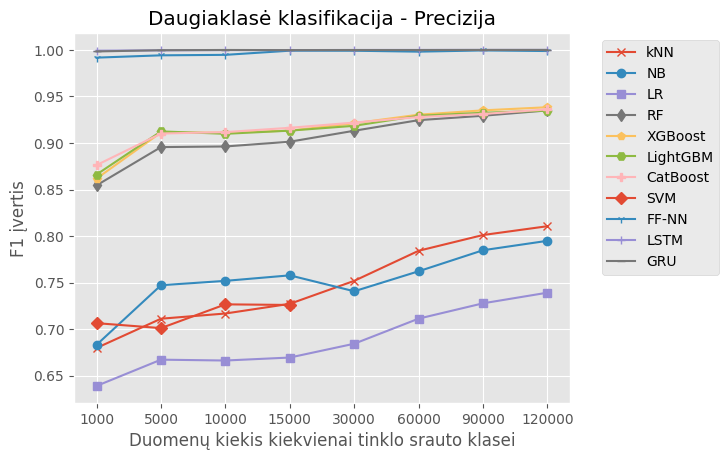

In [77]:
plot_time_series(mc_precision, "Daugiaklasė klasifikacija - Precizija")

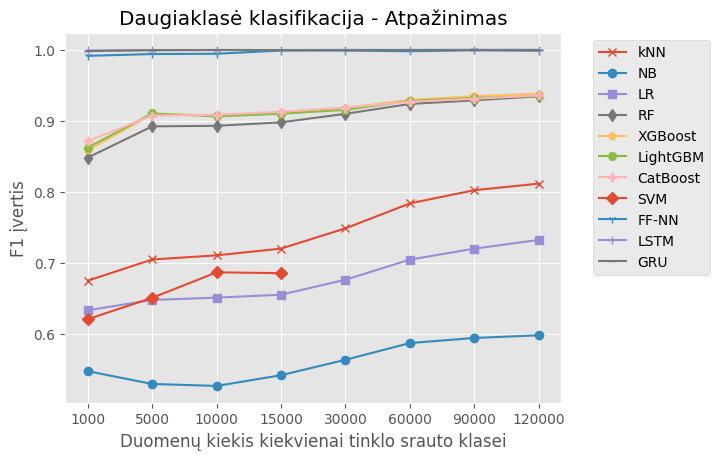

In [21]:
plot_time_series(mc_recall, "Daugiaklasė klasifikacija - Atpažinimas")

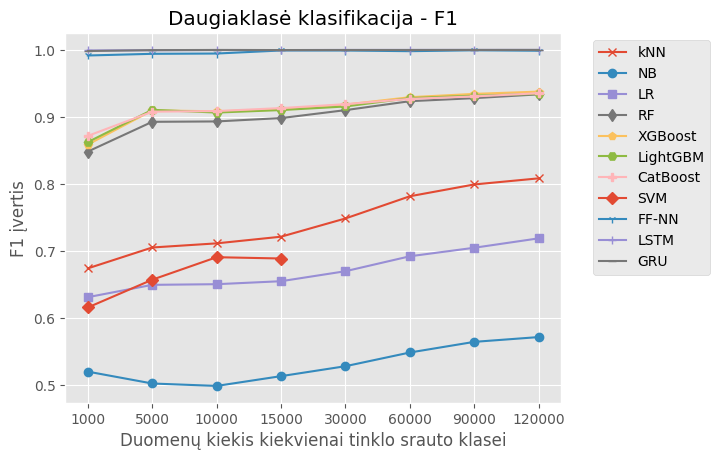

In [22]:
plot_time_series(mc_f1, "Daugiaklasė klasifikacija - F1")

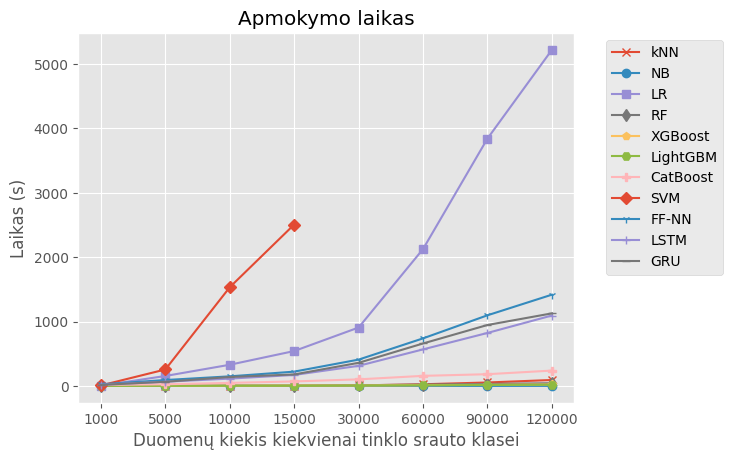

In [23]:
plot_time_series(mc_time, "Apmokymo laikas")

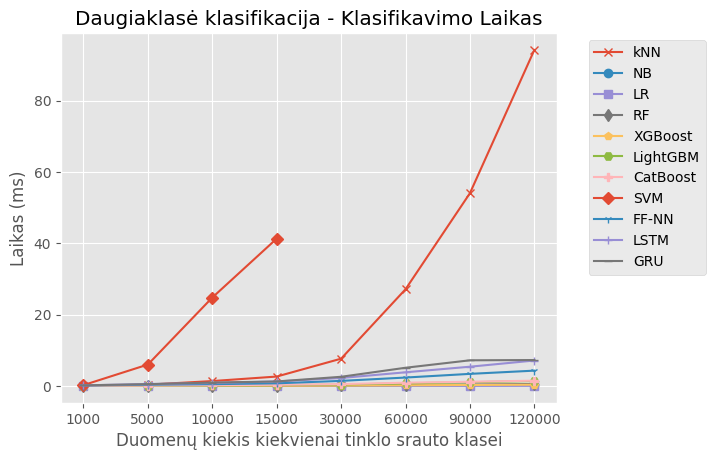

In [24]:
plot_time_series(mc_latency, "Daugiaklasė klasifikacija - Klasifikavimo Laikas")

# Results by class

## Precision

In [25]:
benign_precision, bruteforce_precision, ddos_precision, dos_precision, mirai_precision, recon_precision, spoofing_precision, web_precision = [{} for x in range(8)]

In [26]:
new_dict = load_data('results_1000_precision.txt')
precision_1000 = pd.DataFrame(new_dict).transpose().to_dict()

benign_precision['1000'] = precision_1000['Benign']
bruteforce_precision['1000'] = precision_1000['Bruteforce']
ddos_precision['1000'] = precision_1000['DDoS']
dos_precision['1000'] = precision_1000['DoS']
mirai_precision['1000'] = precision_1000['Mirai']
recon_precision['1000'] = precision_1000['Recon']
spoofing_precision['1000'] = precision_1000['Spoofing']
web_precision['1000'] = precision_1000['Web']

In [27]:
new_dict = load_data('results_5000_precision.txt')
precision_5000 = pd.DataFrame(new_dict).transpose().to_dict()

benign_precision['5000'] = precision_5000['Benign']
bruteforce_precision['5000'] = precision_5000['Bruteforce']
ddos_precision['5000'] = precision_5000['DDoS']
dos_precision['5000'] = precision_5000['DoS']
mirai_precision['5000'] = precision_5000['Mirai']
recon_precision['5000'] = precision_5000['Recon']
spoofing_precision['5000'] = precision_5000['Spoofing']
web_precision['5000'] = precision_5000['Web']

In [28]:
new_dict = load_data('results_10000_precision.txt')
precision_10000 = pd.DataFrame(new_dict).transpose().to_dict()

benign_precision['10000'] = precision_10000['Benign']
bruteforce_precision['10000'] = precision_10000['Bruteforce']
ddos_precision['10000'] = precision_10000['DDoS']
dos_precision['10000'] = precision_10000['DoS']
mirai_precision['10000'] = precision_10000['Mirai']
recon_precision['10000'] = precision_10000['Recon']
spoofing_precision['10000'] = precision_10000['Spoofing']
web_precision['10000'] = precision_10000['Web']

In [29]:
new_dict

{'kNN': {'Benign': 0.651595744680851,
  'Bruteforce': 0.6097724230254351,
  'DDoS': 0.8726198292843073,
  'DoS': 0.9131341209173037,
  'Mirai': 0.9940436796823295,
  'Recon': 0.5723684210526315,
  'Spoofing': 0.5608108108108109,
  'Web': 0.5179856115107914},
 'RF': {'Benign': 0.8969414893617021,
  'Bruteforce': 0.8420348058902276,
  'DDoS': 0.9960604070912672,
  'DoS': 0.995135510771369,
  'Mirai': 0.9973527465254798,
  'Recon': 0.7677631578947368,
  'Spoofing': 0.7932432432432432,
  'Web': 0.8587311968606932},
 'XGBoost': {'Benign': 0.913563829787234,
  'Bruteforce': 0.8520749665327979,
  'DDoS': 0.9986868023637557,
  'DoS': 1.0,
  'Mirai': 1.0,
  'Recon': 0.805921052631579,
  'Spoofing': 0.8162162162162162,
  'Web': 0.881621975147155},
 'LightGBM': {'Benign': 0.9148936170212766,
  'Bruteforce': 0.8480589022757697,
  'DDoS': 0.9973736047275115,
  'DoS': 0.9993050729673384,
  'Mirai': 1.0,
  'Recon': 0.7901315789473684,
  'Spoofing': 0.8148648648648649,
  'Web': 0.8881621975147155},
 '

In [30]:
new_dict = load_data('results_15000_precision.txt')
precision_15000 = pd.DataFrame(new_dict).transpose().to_dict()

benign_precision['15000'] = precision_15000['Benign']
bruteforce_precision['15000'] = precision_15000['Bruteforce']
ddos_precision['15000'] = precision_15000['DDoS']
dos_precision['15000'] = precision_15000['DoS']
mirai_precision['15000'] = precision_15000['Mirai']
recon_precision['15000'] = precision_15000['Recon']
spoofing_precision['15000'] = precision_15000['Spoofing']
web_precision['15000'] = precision_15000['Web']

In [31]:
new_dict = load_data('results_30000_precision.txt')
precision_30000 = pd.DataFrame(new_dict).transpose().to_dict()

benign_precision['30000'] = precision_30000['Benign']
bruteforce_precision['30000'] = precision_30000['Bruteforce']
ddos_precision['30000'] = precision_30000['DDoS']
dos_precision['30000'] = precision_30000['DoS']
mirai_precision['30000'] = precision_30000['Mirai']
recon_precision['30000'] = precision_30000['Recon']
spoofing_precision['30000'] = precision_30000['Spoofing']
web_precision['30000'] = precision_30000['Web']

In [32]:
new_dict = load_data('results_60000_precision.txt')
precision_60000 = pd.DataFrame(new_dict).transpose().to_dict()

benign_precision['60000'] = precision_60000['Benign']
bruteforce_precision['60000'] = precision_60000['Bruteforce']
ddos_precision['60000'] = precision_60000['DDoS']
dos_precision['60000'] = precision_60000['DoS']
mirai_precision['60000'] = precision_60000['Mirai']
recon_precision['60000'] = precision_60000['Recon']
spoofing_precision['60000'] = precision_60000['Spoofing']
web_precision['60000'] = precision_60000['Web']

In [33]:
new_dict = load_data('results_90000_precision.txt')
precision_90000 = pd.DataFrame(new_dict).transpose().to_dict()

benign_precision['90000'] = precision_90000['Benign']
bruteforce_precision['90000'] = precision_90000['Bruteforce']
ddos_precision['90000'] = precision_90000['DDoS']
dos_precision['90000'] = precision_90000['DoS']
mirai_precision['90000'] = precision_90000['Mirai']
recon_precision['90000'] = precision_90000['Recon']
spoofing_precision['90000'] = precision_90000['Spoofing']
web_precision['90000'] = precision_90000['Web']

In [34]:
new_dict = load_data('results_120000_precision.txt')
precision_120000 = pd.DataFrame(new_dict).transpose().to_dict()

benign_precision['120000'] = precision_120000['Benign']
bruteforce_precision['120000'] = precision_120000['Bruteforce']
ddos_precision['120000'] = precision_120000['DDoS']
dos_precision['120000'] = precision_120000['DoS']
mirai_precision['120000'] = precision_120000['Mirai']
recon_precision['120000'] = precision_120000['Recon']
spoofing_precision['120000'] = precision_120000['Spoofing']
web_precision['120000'] = precision_120000['Web']

## Recall

In [35]:
benign_recall, bruteforce_recall, ddos_recall, dos_recall, mirai_recall, recon_recall, spoofing_recall, web_recall = [{} for x in range(8)]

In [36]:
new_dict = load_data('results_1000_recall.txt')
recall_1000 = pd.DataFrame(new_dict).transpose().to_dict()

benign_recall['1000'] = recall_1000['Benign']
bruteforce_recall['1000'] = recall_1000['Bruteforce']
ddos_recall['1000'] = recall_1000['DDoS']
dos_recall['1000'] = recall_1000['DoS']
mirai_recall['1000'] = recall_1000['Mirai']
recon_recall['1000'] = recall_1000['Recon']
spoofing_recall['1000'] = recall_1000['Spoofing']
web_recall['1000'] = recall_1000['Web']

In [37]:
new_dict = load_data('results_5000_recall.txt')
recall_5000 = pd.DataFrame(new_dict).transpose().to_dict()

benign_recall['5000'] = recall_5000['Benign']
bruteforce_recall['5000'] = recall_5000['Bruteforce']
ddos_recall['5000'] = recall_5000['DDoS']
dos_recall['5000'] = recall_5000['DoS']
mirai_recall['5000'] = recall_5000['Mirai']
recon_recall['5000'] = recall_5000['Recon']
spoofing_recall['5000'] = recall_5000['Spoofing']
web_recall['5000'] = recall_5000['Web']

In [38]:
new_dict = load_data('results_10000_recall.txt')
recall_10000 = pd.DataFrame(new_dict).transpose().to_dict()

benign_recall['10000'] = recall_10000['Benign']
bruteforce_recall['10000'] = recall_10000['Bruteforce']
ddos_recall['10000'] = recall_10000['DDoS']
dos_recall['10000'] = recall_10000['DoS']
mirai_recall['10000'] = recall_10000['Mirai']
recon_recall['10000'] = recall_10000['Recon']
spoofing_recall['10000'] = recall_10000['Spoofing']
web_recall['10000'] = recall_10000['Web']

In [39]:
new_dict = load_data('results_15000_recall.txt')
recall_15000 = pd.DataFrame(new_dict).transpose().to_dict()

benign_recall['15000'] = recall_15000['Benign']
bruteforce_recall['15000'] = recall_15000['Bruteforce']
ddos_recall['15000'] = recall_15000['DDoS']
dos_recall['15000'] = recall_15000['DoS']
mirai_recall['15000'] = recall_15000['Mirai']
recon_recall['15000'] = recall_15000['Recon']
spoofing_recall['15000'] = recall_15000['Spoofing']
web_recall['15000'] = recall_15000['Web']

In [40]:
new_dict = load_data('results_30000_recall.txt')
recall_30000 = pd.DataFrame(new_dict).transpose().to_dict()

benign_recall['30000'] = recall_30000['Benign']
bruteforce_recall['30000'] = recall_30000['Bruteforce']
ddos_recall['30000'] = recall_30000['DDoS']
dos_recall['30000'] = recall_30000['DoS']
mirai_recall['30000'] = recall_30000['Mirai']
recon_recall['30000'] = recall_30000['Recon']
spoofing_recall['30000'] = recall_30000['Spoofing']
web_recall['30000'] = recall_30000['Web']

In [41]:
new_dict = load_data('results_60000_recall.txt')
recall_60000 = pd.DataFrame(new_dict).transpose().to_dict()

benign_recall['60000'] = recall_60000['Benign']
bruteforce_recall['60000'] = recall_60000['Bruteforce']
ddos_recall['60000'] = recall_60000['DDoS']
dos_recall['60000'] = recall_60000['DoS']
mirai_recall['60000'] = recall_60000['Mirai']
recon_recall['60000'] = recall_60000['Recon']
spoofing_recall['60000'] = recall_60000['Spoofing']
web_recall['60000'] = recall_60000['Web']

In [42]:
new_dict = load_data('results_90000_recall.txt')
recall_90000 = pd.DataFrame(new_dict).transpose().to_dict()

benign_recall['90000'] = recall_90000['Benign']
bruteforce_recall['90000'] = recall_90000['Bruteforce']
ddos_recall['90000'] = recall_90000['DDoS']
dos_recall['90000'] = recall_90000['DoS']
mirai_recall['90000'] = recall_90000['Mirai']
recon_recall['90000'] = recall_90000['Recon']
spoofing_recall['90000'] = recall_90000['Spoofing']
web_recall['90000'] = recall_90000['Web']

In [43]:
new_dict = load_data('results_120000_recall.txt')
recall_120000 = pd.DataFrame(new_dict).transpose().to_dict()

benign_recall['120000'] = recall_120000['Benign']
bruteforce_recall['120000'] = recall_120000['Bruteforce']
ddos_recall['120000'] = recall_120000['DDoS']
dos_recall['120000'] = recall_120000['DoS']
mirai_recall['120000'] = recall_120000['Mirai']
recon_recall['120000'] = recall_120000['Recon']
spoofing_recall['120000'] = recall_120000['Spoofing']
web_recall['120000'] = recall_120000['Web']

# F1

In [44]:
benign_f1, bruteforce_f1, ddos_f1, dos_f1, mirai_f1, recon_f1, spoofing_f1, web_f1 = [{} for x in range(8)]

In [45]:
new_dict = load_data('results_1000_f1.txt')
f1_1000 = pd.DataFrame(new_dict).transpose().to_dict()

benign_f1['1000'] = f1_1000['Benign']
bruteforce_f1['1000'] = f1_1000['Bruteforce']
ddos_f1['1000'] = f1_1000['DDoS']
dos_f1['1000'] = f1_1000['DoS']
mirai_f1['1000'] = f1_1000['Mirai']
recon_f1['1000'] = f1_1000['Recon']
spoofing_f1['1000'] = f1_1000['Spoofing']
web_f1['1000'] = f1_1000['Web']

In [46]:
new_dict = load_data('results_5000_f1.txt')
f1_5000 = pd.DataFrame(new_dict).transpose().to_dict()

benign_f1['5000'] = f1_5000['Benign']
bruteforce_f1['5000'] = f1_5000['Bruteforce']
ddos_f1['5000'] = f1_5000['DDoS']
dos_f1['5000'] = f1_5000['DoS']
mirai_f1['5000'] = f1_5000['Mirai']
recon_f1['5000'] = f1_5000['Recon']
spoofing_f1['5000'] = f1_5000['Spoofing']
web_f1['5000'] = f1_5000['Web']

In [47]:
new_dict = load_data('results_10000_f1.txt')
f1_10000 = pd.DataFrame(new_dict).transpose().to_dict()

benign_f1['10000'] = f1_10000['Benign']
bruteforce_f1['10000'] = f1_10000['Bruteforce']
ddos_f1['10000'] = f1_10000['DDoS']
dos_f1['10000'] = f1_10000['DoS']
mirai_f1['10000'] = f1_10000['Mirai']
recon_f1['10000'] = f1_10000['Recon']
spoofing_f1['10000'] = f1_10000['Spoofing']
web_f1['10000'] = f1_10000['Web']

In [48]:
new_dict = load_data('results_15000_f1.txt')
f1_15000 = pd.DataFrame(new_dict).transpose().to_dict()

benign_f1['15000'] = f1_15000['Benign']
bruteforce_f1['15000'] = f1_15000['Bruteforce']
ddos_f1['15000'] = f1_15000['DDoS']
dos_f1['15000'] = f1_15000['DoS']
mirai_f1['15000'] = f1_15000['Mirai']
recon_f1['15000'] = f1_15000['Recon']
spoofing_f1['15000'] = f1_15000['Spoofing']
web_f1['15000'] = f1_15000['Web']

In [49]:
new_dict = load_data('results_30000_f1.txt')
f1_30000 = pd.DataFrame(new_dict).transpose().to_dict()

benign_f1['30000'] = f1_30000['Benign']
bruteforce_f1['30000'] = f1_30000['Bruteforce']
ddos_f1['30000'] = f1_30000['DDoS']
dos_f1['30000'] = f1_30000['DoS']
mirai_f1['30000'] = f1_30000['Mirai']
recon_f1['30000'] = f1_30000['Recon']
spoofing_f1['30000'] = f1_30000['Spoofing']
web_f1['30000'] = f1_30000['Web']

In [50]:
new_dict = load_data('results_60000_f1.txt')
f1_60000 = pd.DataFrame(new_dict).transpose().to_dict()

benign_f1['60000'] = f1_60000['Benign']
bruteforce_f1['60000'] = f1_60000['Bruteforce']
ddos_f1['60000'] = f1_60000['DDoS']
dos_f1['60000'] = f1_60000['DoS']
mirai_f1['60000'] = f1_60000['Mirai']
recon_f1['60000'] = f1_60000['Recon']
spoofing_f1['60000'] = f1_60000['Spoofing']
web_f1['60000'] = f1_60000['Web']

In [51]:
new_dict = load_data('results_90000_f1.txt')
f1_90000 = pd.DataFrame(new_dict).transpose().to_dict()

benign_f1['90000'] = f1_90000['Benign']
bruteforce_f1['90000'] = f1_90000['Bruteforce']
ddos_f1['90000'] = f1_90000['DDoS']
dos_f1['90000'] = f1_90000['DoS']
mirai_f1['90000'] = f1_90000['Mirai']
recon_f1['90000'] = f1_90000['Recon']
spoofing_f1['90000'] = f1_90000['Spoofing']
web_f1['90000'] = f1_90000['Web']

In [52]:
new_dict = load_data('results_120000_f1.txt')
f1_120000 = pd.DataFrame(new_dict).transpose().to_dict()

benign_f1['120000'] = f1_120000['Benign']
bruteforce_f1['120000'] = f1_120000['Bruteforce']
ddos_f1['120000'] = f1_120000['DDoS']
dos_f1['120000'] = f1_120000['DoS']
mirai_f1['120000'] = f1_120000['Mirai']
recon_f1['120000'] = f1_120000['Recon']
spoofing_f1['120000'] = f1_120000['Spoofing']
web_f1['120000'] = f1_120000['Web']

# Plot results by class

## Precision

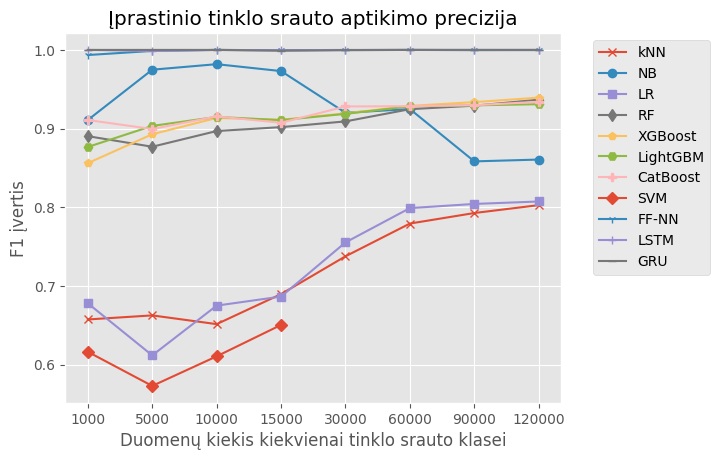

In [53]:
benign_precision = pd.DataFrame(benign_precision).transpose()
plot_time_series(benign_precision, "Įprastinio tinklo srauto aptikimo precizija")

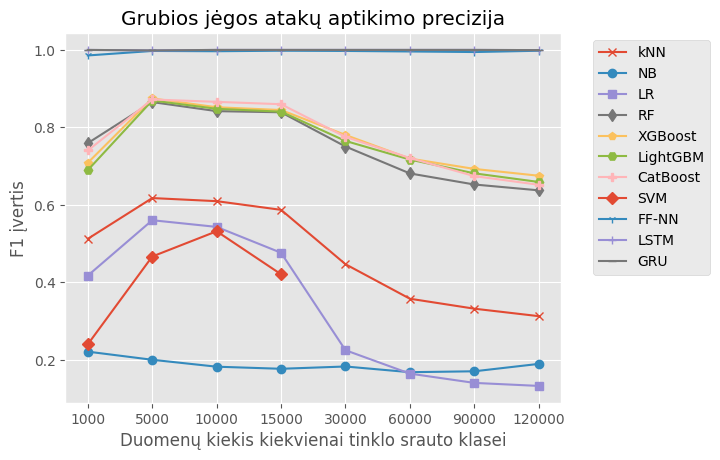

In [54]:
bruteforce_precision = pd.DataFrame(bruteforce_precision).transpose()
plot_time_series(bruteforce_precision, "Grubios jėgos atakų aptikimo precizija")

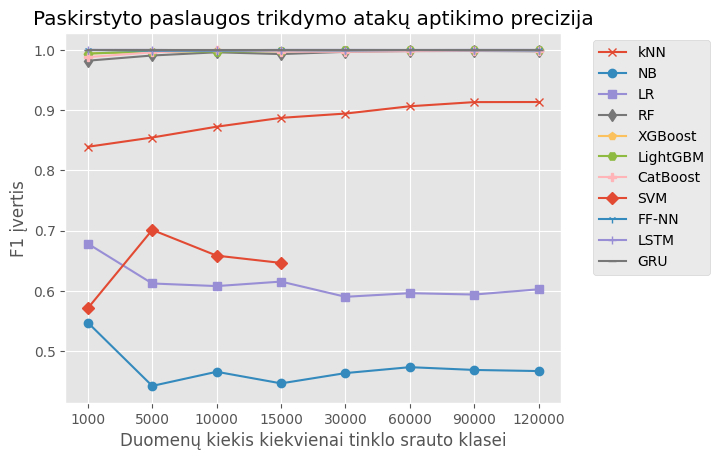

In [55]:
ddos_precision = pd.DataFrame(ddos_precision).transpose()
plot_time_series(ddos_precision, "Paskirstyto paslaugos trikdymo atakų aptikimo precizija")

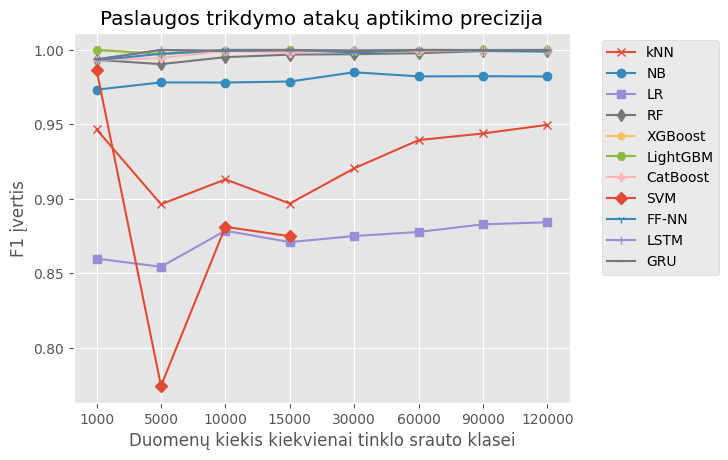

In [56]:
dos_precision = pd.DataFrame(dos_precision).transpose()
plot_time_series(dos_precision, "Paslaugos trikdymo atakų aptikimo precizija")

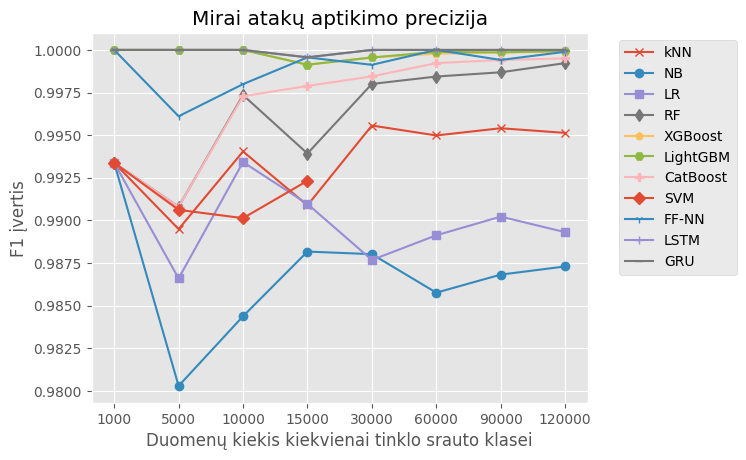

In [57]:
mirai_precision = pd.DataFrame(mirai_precision).transpose()
plot_time_series(mirai_precision, "Mirai atakų aptikimo precizija")

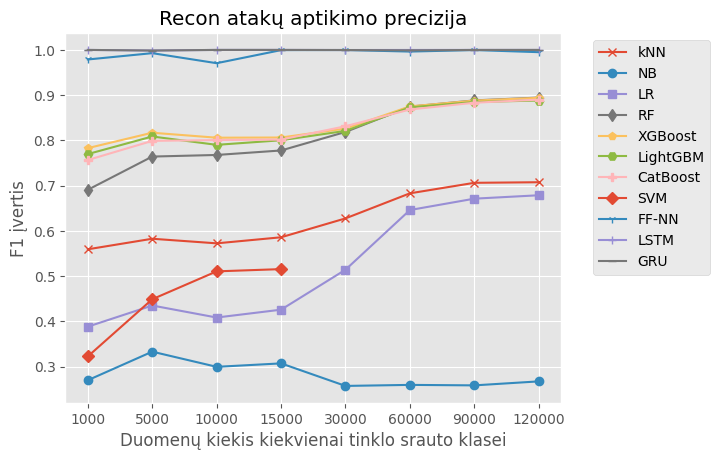

In [58]:
recon_precision = pd.DataFrame(recon_precision).transpose()
plot_time_series(recon_precision, "Recon atakų aptikimo precizija")

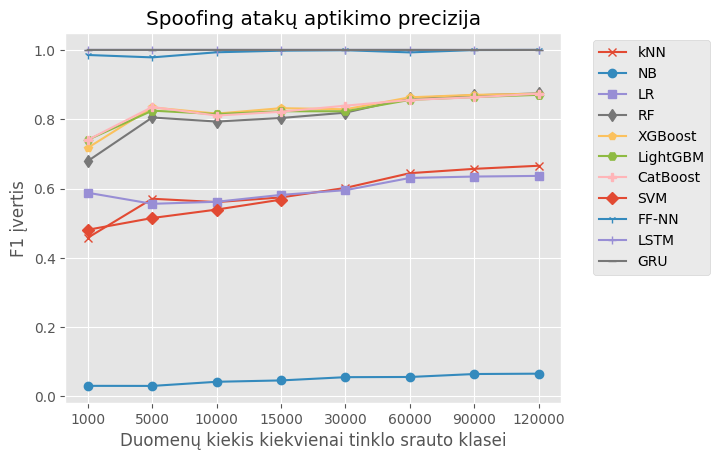

In [59]:
spoofing_precision = pd.DataFrame(spoofing_precision).transpose()
plot_time_series(spoofing_precision, "Spoofing atakų aptikimo precizija")

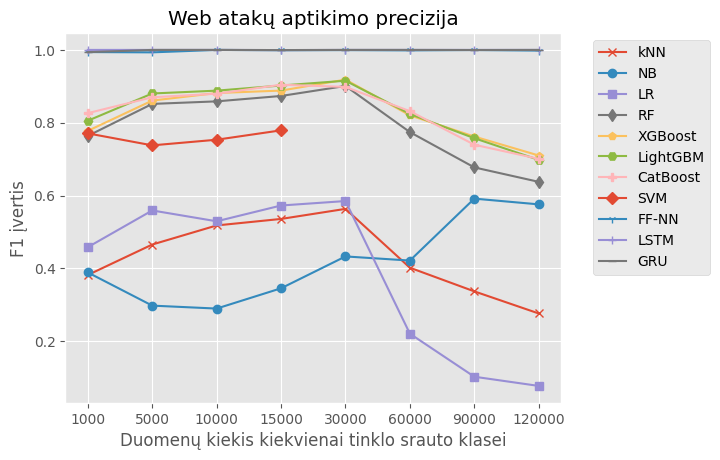

In [60]:
web_precision = pd.DataFrame(web_precision).transpose()
plot_time_series(web_precision, "Web atakų aptikimo precizija")

## Recall

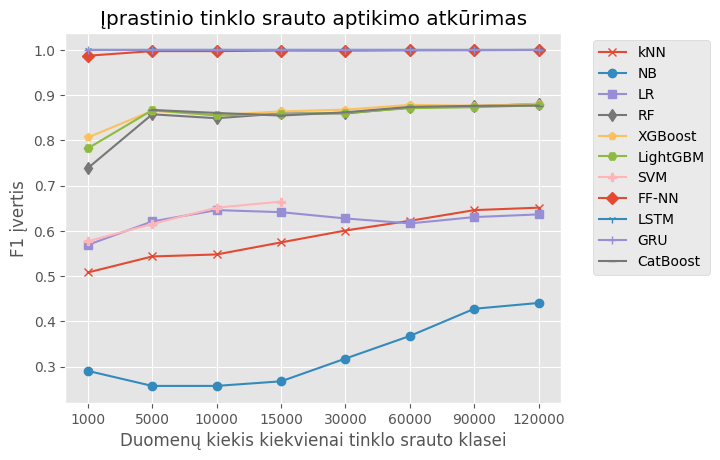

In [61]:
benign_recall = pd.DataFrame(benign_recall).transpose()
plot_time_series(benign_recall, "Įprastinio tinklo srauto aptikimo atkūrimas")

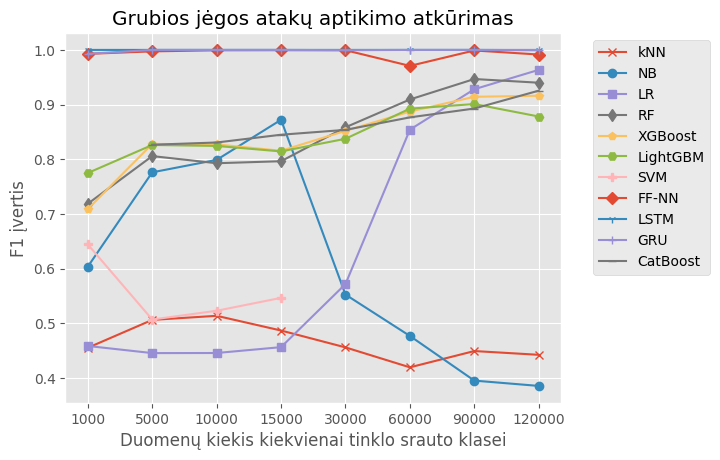

In [62]:
bruteforce_recall = pd.DataFrame(bruteforce_recall).transpose()
plot_time_series(bruteforce_recall, "Grubios jėgos atakų aptikimo atkūrimas")

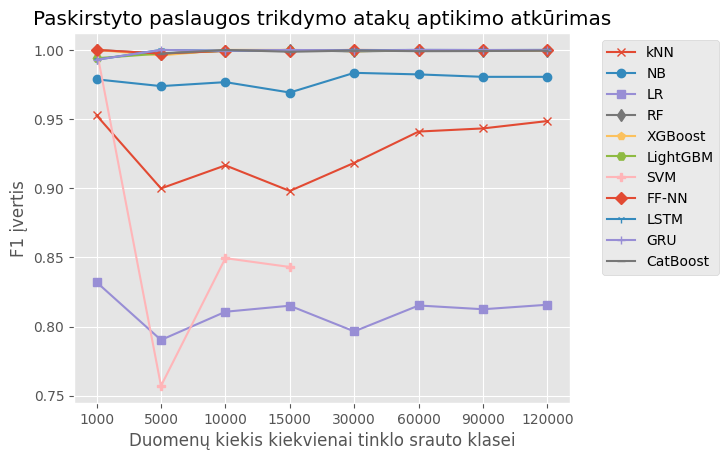

In [63]:
ddos_recall = pd.DataFrame(ddos_recall).transpose()
plot_time_series(ddos_recall, "Paskirstyto paslaugos trikdymo atakų aptikimo atkūrimas")

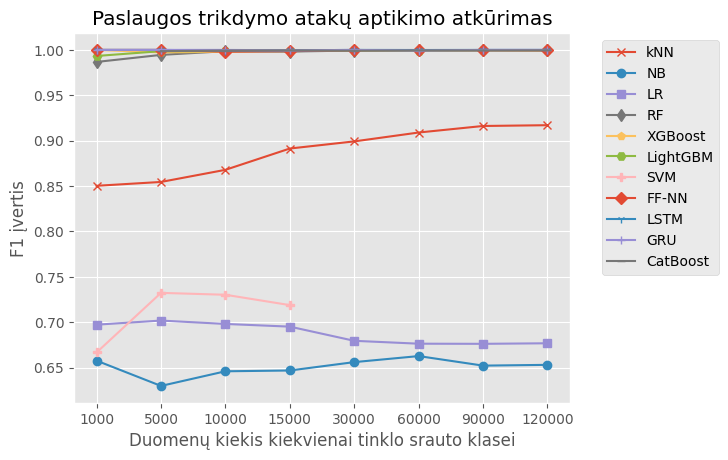

In [64]:
dos_recall = pd.DataFrame(dos_recall).transpose()
plot_time_series(dos_recall, "Paslaugos trikdymo atakų aptikimo atkūrimas")

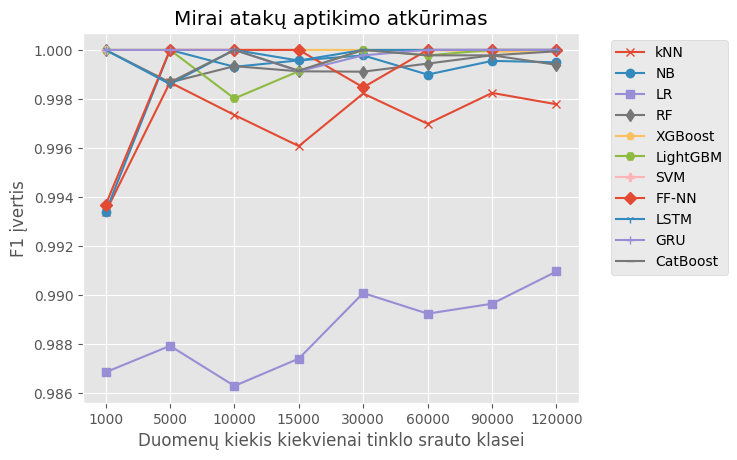

In [65]:
mirai_recall = pd.DataFrame(mirai_recall).transpose()
plot_time_series(mirai_recall, "Mirai atakų aptikimo atkūrimas")

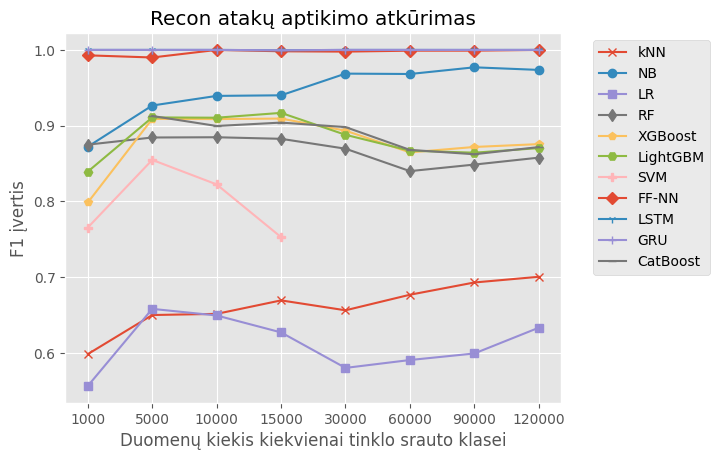

In [66]:
recon_recall = pd.DataFrame(recon_recall).transpose()
plot_time_series(recon_recall, "Recon atakų aptikimo atkūrimas")

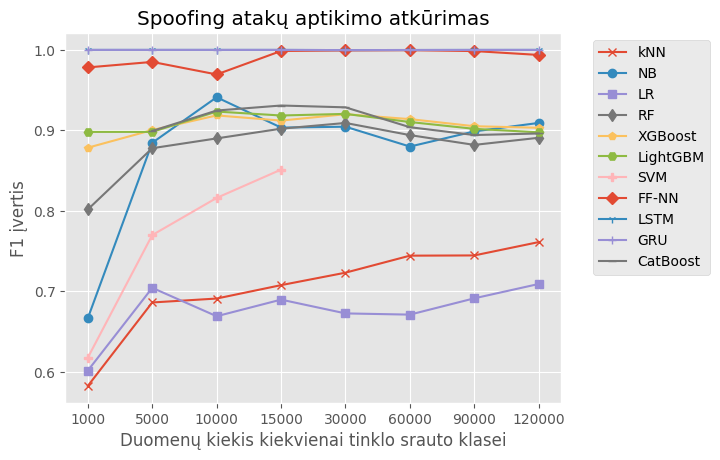

In [67]:
spoofing_recall = pd.DataFrame(spoofing_recall).transpose()
plot_time_series(spoofing_recall, "Spoofing atakų aptikimo atkūrimas")

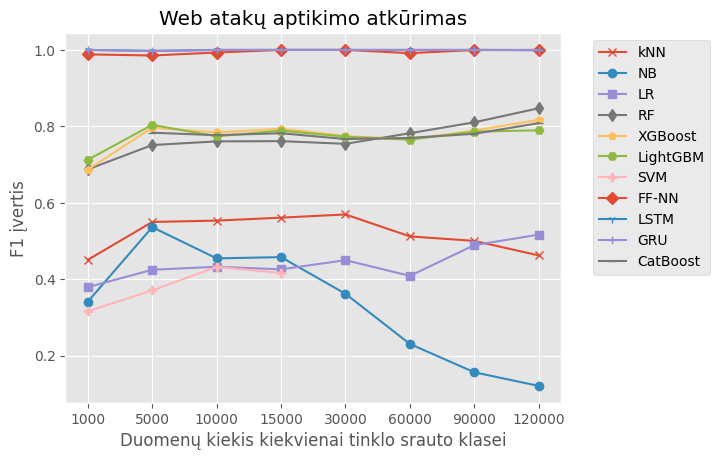

In [68]:
web_recall = pd.DataFrame(web_recall).transpose()
plot_time_series(web_recall, "Web atakų aptikimo atkūrimas")

## F1

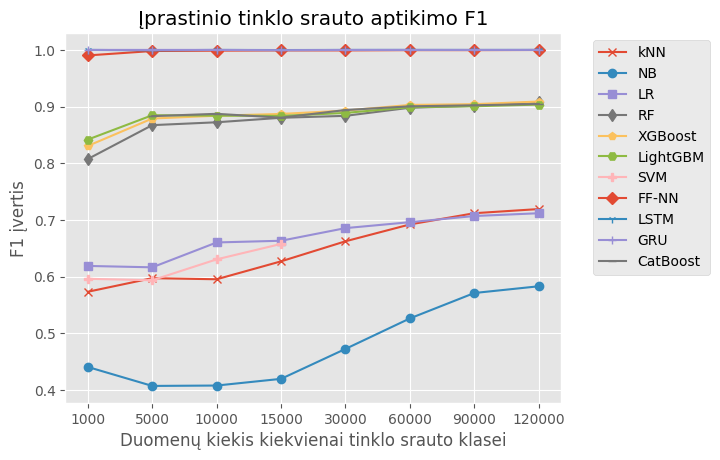

In [69]:
benign_f1 = pd.DataFrame(benign_f1).transpose()
plot_time_series(benign_f1, "Įprastinio tinklo srauto aptikimo F1")

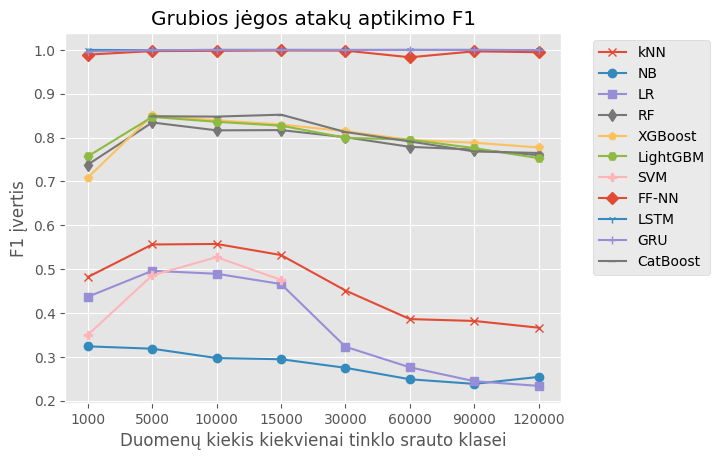

In [70]:
bruteforce_f1 = pd.DataFrame(bruteforce_f1).transpose()
plot_time_series(bruteforce_f1, "Grubios jėgos atakų aptikimo F1")

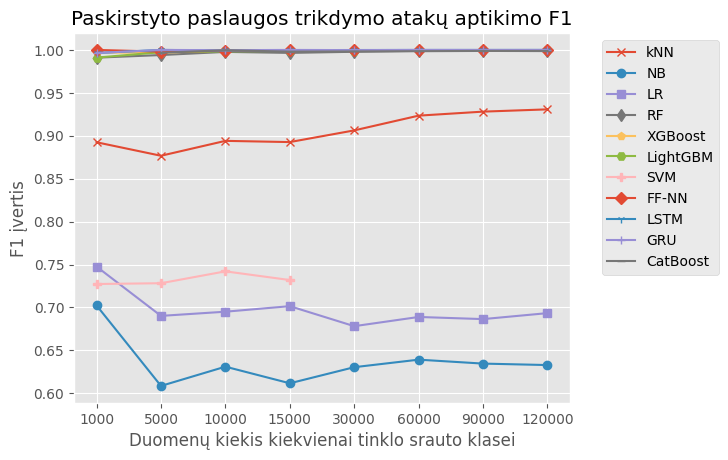

In [71]:
ddos_f1 = pd.DataFrame(ddos_f1).transpose()
plot_time_series(ddos_f1, "Paskirstyto paslaugos trikdymo atakų aptikimo F1")

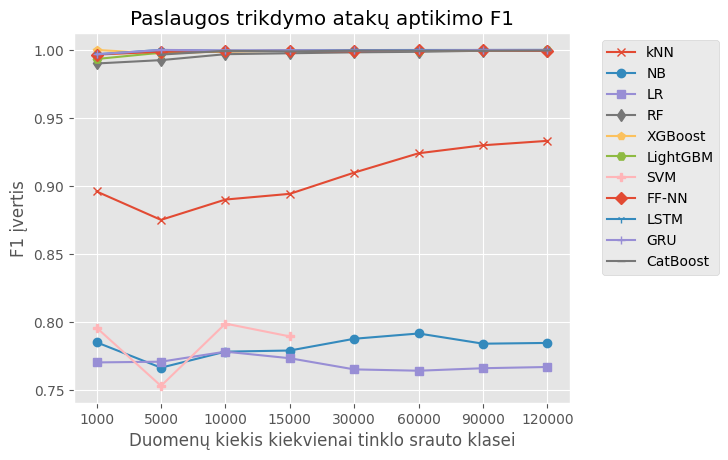

In [72]:
dos_f1 = pd.DataFrame(dos_f1).transpose()
plot_time_series(dos_f1, "Paslaugos trikdymo atakų aptikimo F1")

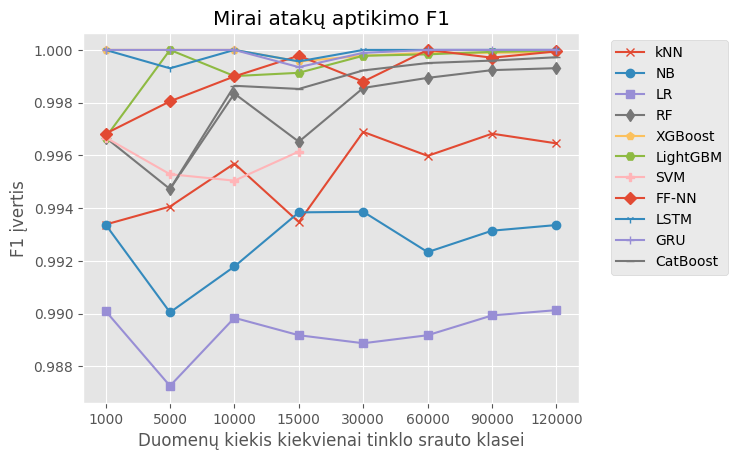

In [73]:
mirai_f1 = pd.DataFrame(mirai_f1).transpose()
plot_time_series(mirai_f1, "Mirai atakų aptikimo F1")

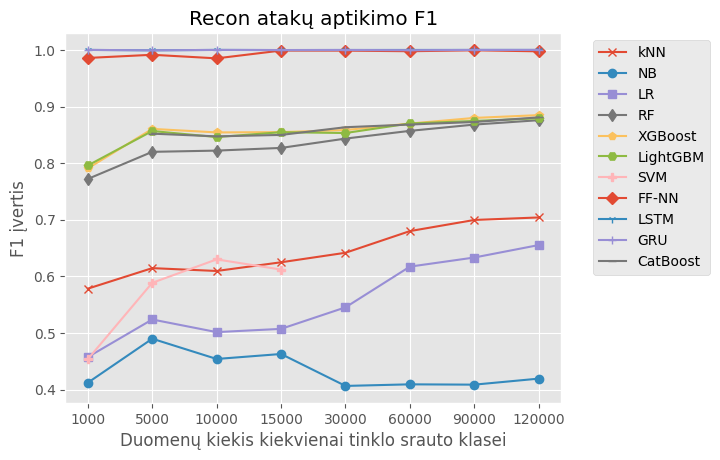

In [74]:
recon_f1 = pd.DataFrame(recon_f1).transpose()
plot_time_series(recon_f1, "Recon atakų aptikimo F1")

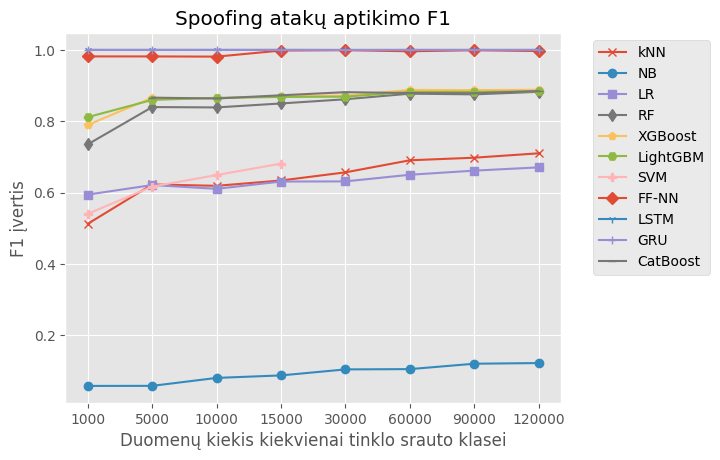

In [75]:
spoofing_f1 = pd.DataFrame(spoofing_f1).transpose()
plot_time_series(spoofing_f1, "Spoofing atakų aptikimo F1")

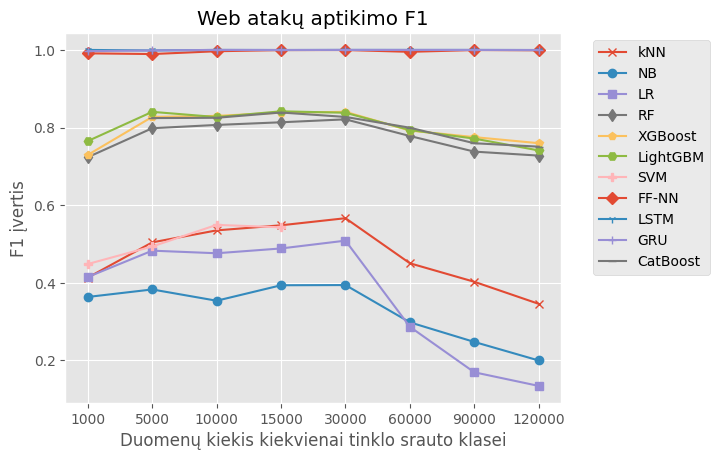

In [76]:
web_f1 = pd.DataFrame(web_f1).transpose()
plot_time_series(web_f1, "Web atakų aptikimo F1")